# Idealista Exploratory Data Analysis (EDA)

In this notebook, we are going to perform a simple exploratory data analysis of the previously cleaned data.

For this dataset, we're going to perform a really basic data analysis to observe:

- How the prices vary across different regions
- How distance to state capital increases or decreases the property price

First of all, we will load the csv file (`idealista_clean.csv`) created on the 1st notebook (1.Reading Data.ipynb).

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/processed/idealista_clean.csv')
df.head()

,propertyCode,thumbnail,numPhotos,floor,price,propertyType,operation,size,exterior,rooms,...,has360,topNewDevelopment,detailedType_typology,suggestedTexts_subtitle,suggestedTexts_title,detailedType_subTypology,parkingSpace_hasParkingSpace,parkingSpace_isParkingSpaceIncludedInPrice,parkingSpace_parkingSpacePrice,neighborhood
0,90142313,https://img3.idealista.com/blur/WEB_LISTING/0/...,10,1,520.0,flat,rent,55.0,True,1,...,False,False,flat,"Centro, Melilla","Piso en Calle Explorador Badía, 41",unknown,False,False,0.0,Unknown
1,90142099,https://img3.idealista.com/blur/WEB_LISTING/0/...,11,en,420.0,studio,rent,45.0,True,0,...,False,False,flat,"Centro, Melilla","Estudio en Calle Explorador Badía, 41",studio,False,False,0.0,Unknown
2,90141814,https://img3.idealista.com/blur/WEB_LISTING/0/...,18,3,680.0,flat,rent,65.0,True,2,...,False,False,flat,"Centro, Melilla","Piso en Calle Explorador Badía, 41",unknown,False,False,0.0,Unknown
3,81959602,https://img3.idealista.com/blur/WEB_LISTING/0/...,23,2,650.0,flat,rent,105.0,True,3,...,False,False,flat,"El Industrial, Melilla","Piso en Calle General Polavieja, Melilla s/n",unknown,False,False,0.0,Unknown
4,90128666,https://img3.idealista.com/blur/WEB_LISTING/0/...,22,en,650.0,flat,rent,75.0,True,2,...,False,False,flat,"El Industrial, Melilla","Piso en Plaza de la Goleta, 5",unknown,False,False,0.0,Unknown


## Price analysis

### Average Price by province

If we take a look at this current dataset, each flat is located in a single city. The idea is to calculate the average price of renting a flat by city.

Just with that, we can already visualize some data, for instance, the flats in Barcelona are more expensive than the ones in Lleida, which is actually the city with the lowest average among the available cities.

In [4]:
data = df.groupby('province')['price'].mean()
data = data.sort_values(ascending=False)
data

province
Gibraltar                 3000.000000
Balears (Illes)           1653.446667
Madrid                    1570.425000
Cádiz                     1543.289520
Barcelona                 1541.515888
Cantabria                 1336.617647
València                  1116.566316
Vizcaya                   1103.910906
Alicante                  1096.391304
León                      1000.000000
Navarra                    993.094118
Pontevedra                 976.081288
Málaga                     935.802850
Las Palmas                 911.274797
Sevilla                    892.796513
Tarragona                  856.175000
Santa Cruz de Tenerife     847.325000
Álava                      831.551724
Girona                     817.088353
A Coruña                   787.201722
Ceuta                      762.500000
Zaragoza                   718.464286
Guipúzcoa                  716.666667
Murcia                     702.214909
Melilla                    686.600000
Valladolid                 663.010782
Gra

To facilitate the visualization, we can also plot a chart with that information.

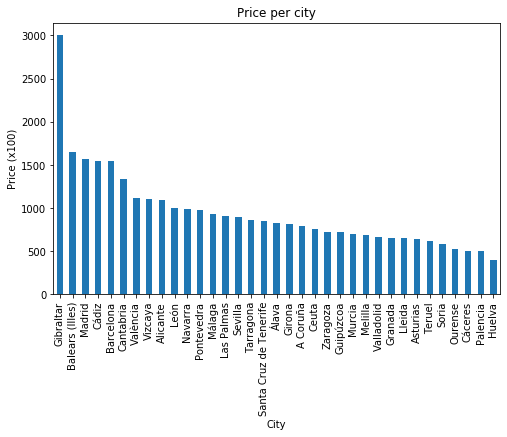

In [5]:
plt.title('Price per city')
data.plot.bar(figsize=(8, 5))
plt.xlabel('City')
plt.ylabel('Price (x100)');

We can take the comparison a set further and compare the distributions for each state.

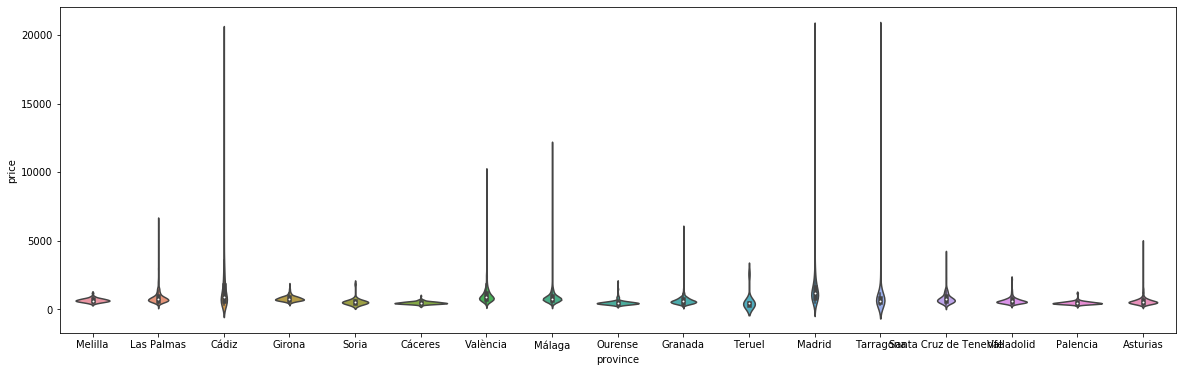

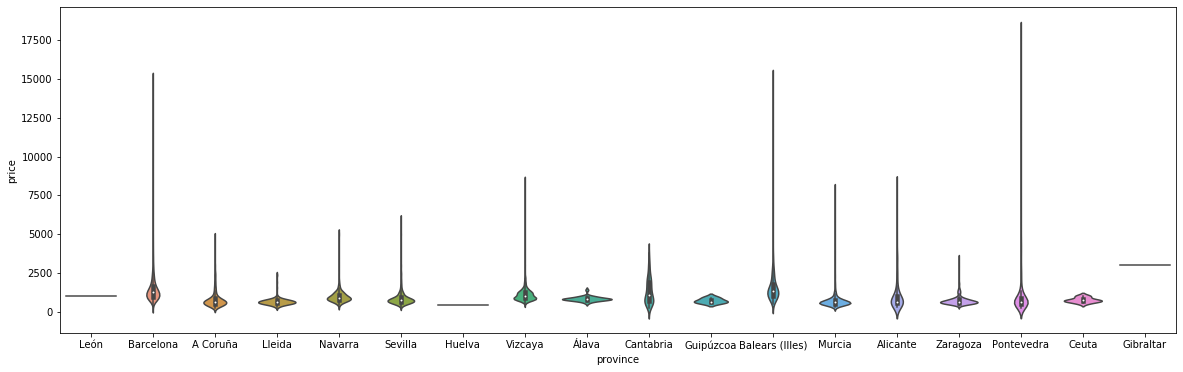

In [6]:
plt.figure(figsize=(20, 6))
un_provinces = df.province.unique()
sns.violinplot(x='province', y='price', data=df[df.province.isin(un_provinces[:len(un_provinces) // 2])]);

plt.figure(figsize=(20, 6))
un_provinces = df.province.unique()
sns.violinplot(x='province', y='price', data=df[df.province.isin(un_provinces[len(un_provinces) // 2:])]);

For most of the states, the price distributions are not central, they stick around low values, but there are also some properties that are "pulling" the mean up (they are outliers). This means that the most properties in that city are around the mean of around 1000€ but there are some that are really expensive.

This behavior is observed in big or touristic cities such as: Islas Baleares, Mallorca, Madrid, and Barcelona.  On theory which could explain this, is the vast presence of tourists and businessmen, which are whiling to pay higher prices for rent.

Meanwhile, the common cities which are not as much touristic such as Lleida, Palencia, and Girona, have more central distribution, near to a normal one.

The following plots give us better insights into the price distribution by the city.

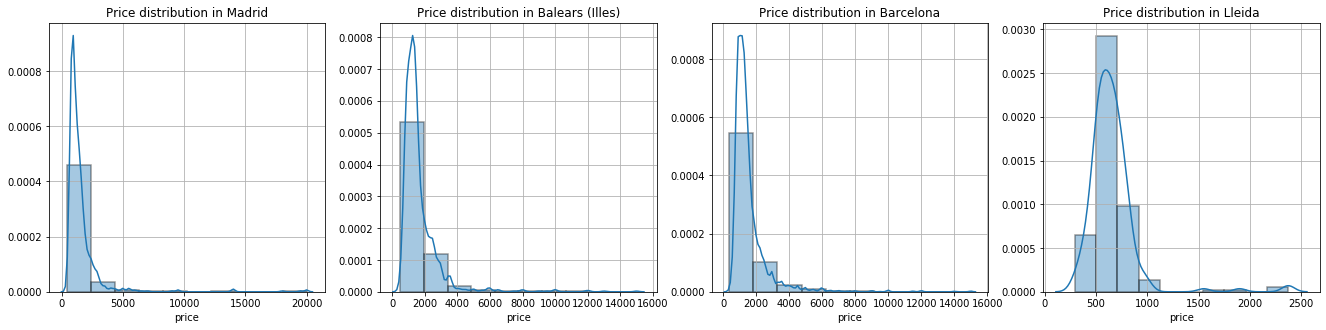

In [7]:
plt.figure(figsize=(100, 100))
n_states = len(df.province.unique())
for i, state in enumerate(['Madrid', 'Balears (Illes)', 'Barcelona', 'Lleida'], start=1):
    plt.subplot(n_states // 2, n_states // 2, i)
    plt.title(f'Price distribution in {state}')
    sns.distplot(df[df.province == state].price,
                 bins=10,
                 hist_kws=dict(edgecolor='black', linewidth=1.5))
    plt.grid('on')

Using some basic commands, we are also able to calculate the average (mean), the standard deviation (std), and the median of prices by city.

In [8]:
central_stats = dict()
for state in df.province.unique():
    mean = df[df.province == state].price.mean()
    std = df[df.province == state].price.std()
    median = df[df.province == state].price.median()
    central_stats[state] = dict(mean=mean, std=std, median=median)
central_stats_df = pd.DataFrame(central_stats)

Cáceres, Palencia and Huelva are the cities where the rent prices are the lowest, while the highest prices are in Gibraltar, Islas Baleares, Cádiz, Mallorca, Madrid, and Barcelona.

It is important to note that both Huelva and Gibraltar, are probably outliers, since by analyzing the charts, the dataset probably only includes one property of each one of these cities, making it a probably inaccurate sample.

Also as earlier mentioned and as expected, touristic cities have a higher standard deviation, this is because there are flats that are thought for daily life, while others are thought for holidays. These last ones are more expensive.

### Price by state and area

In this section, we repeat the previous analysis but using the price per $m^2$. We do that because this is more accurate when comparing multiple properties. For instance, in the previous section, we were comparing flats of very different dimensions.

In [9]:
data = df.groupby('province')['priceByArea'].mean()
data = data.sort_values(ascending=False)
data

province
Gibraltar                 23.000000
Barcelona                 17.036636
Madrid                    15.996250
Cantabria                 15.215686
Vizcaya                   12.773425
Balears (Illes)           12.766667
Las Palmas                12.458808
Ceuta                     11.375000
Málaga                    10.965321
València                  10.698421
Cádiz                     10.535524
Sevilla                   10.246642
Girona                     9.594378
Pontevedra                 9.524540
Alicante                   9.239130
Santa Cruz de Tenerife     9.100000
Álava                      9.068966
Navarra                    9.015686
Tarragona                  8.815000
Zaragoza                   8.700000
Granada                    8.409676
Guipúzcoa                  8.333333
Asturias                   8.318956
A Coruña                   8.285363
Melilla                    8.260000
Murcia                     7.799366
Valladolid                 7.544474
Lleida             

We can see that the trend is almost the same as the previous plots.

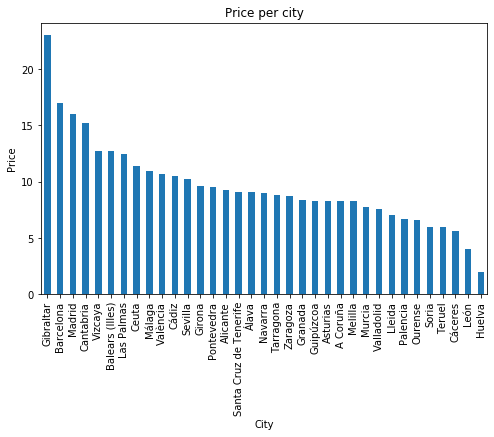

In [10]:
plt.title('Price per city')
data.plot.bar(figsize=(8, 5))
plt.xlabel('City')
plt.ylabel('Price');

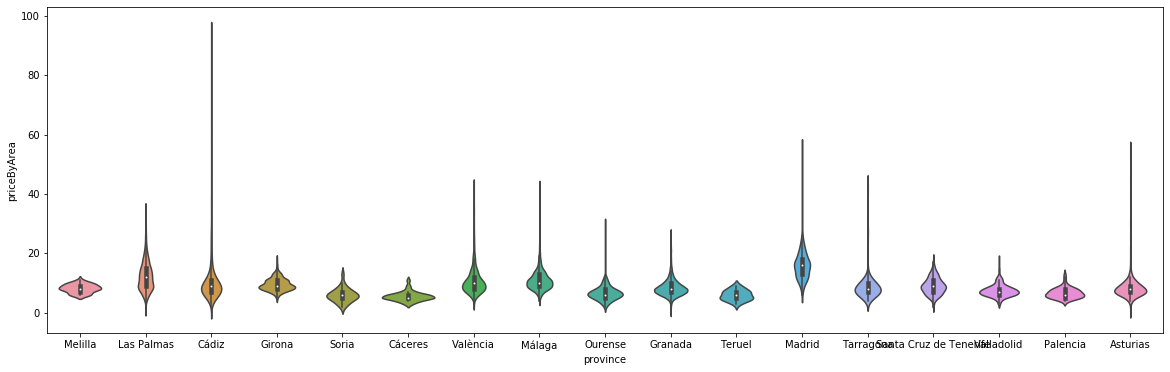

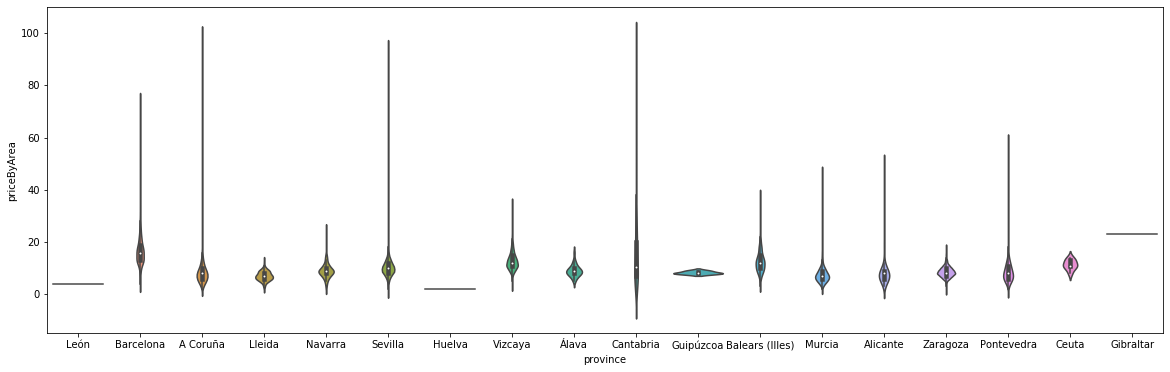

In [11]:
plt.figure(figsize=(20, 6))
un_provinces = df.province.unique()
sns.violinplot(x='province', y='priceByArea', data=df[df.province.isin(un_provinces[:len(un_provinces) // 2])]);

plt.figure(figsize=(20, 6))
un_provinces = df.province.unique()
sns.violinplot(x='province', y='priceByArea', data=df[df.province.isin(un_provinces[len(un_provinces) // 2:])]);

### Average price by type of property

As we know the properties that appear on Idealista can be very different. For instance, in this next part, we can see the different types of properties that exist on this dataset. Each one could be very different than other and this also affects their prices.

In [12]:
central_stats = dict()
for prop_type in df.propertyType.unique():
    mean = df[df.propertyType == prop_type].priceByArea.mean()
    std = df[df.propertyType == prop_type].priceByArea.std()
    median = df[df.propertyType == prop_type].priceByArea.median()
    central_stats[prop_type] = dict(mean=mean, std=std, median=median)
central_stats_df = pd.DataFrame(central_stats)
central_stats_df

,flat,studio,penthouse,chalet,duplex,countryHouse
mean,11.290019,14.699617,13.107737,10.746103,11.331586,8.814286
std,5.210810,5.304259,6.291804,6.902208,5.179597,6.712076
median,10.000000,14.000000,12.000000,9.000000,11.000000,7.500000


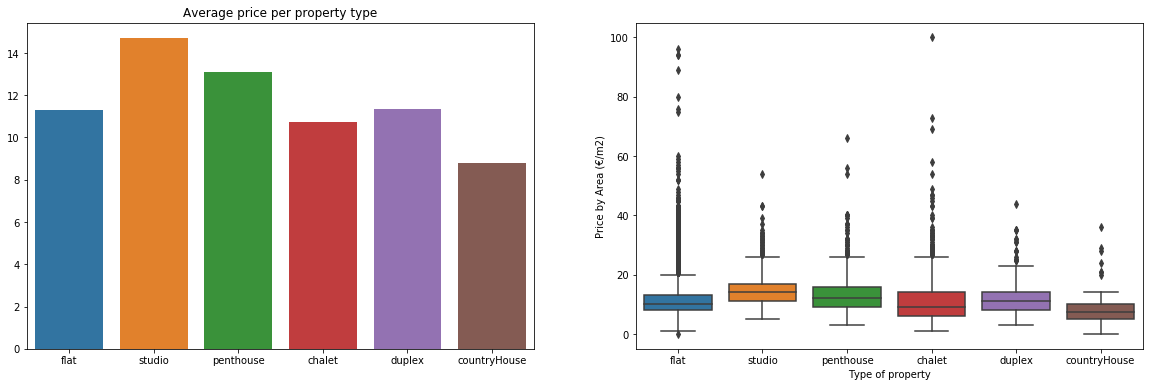

In [13]:
plt.figure(figsize=(20, 6))
plt.subplot(121)

plt.title('Average price per property type')
sns.barplot(x=central_stats_df.columns, 
            y=central_stats_df.loc['mean'].values)

plt.subplot(122)
sns.boxplot(x="propertyType", y="priceByArea", data=df)
plt.ylabel('Price by Area (€/m2)')
plt.xlabel('Type of property')
plt.show()

Taking into account that we are comparing by the price and not by the area, we observe that the studios are the most expensive type of property. Even though flats have a lot of expensive outliers, probably belonging to more expensive cities such as Mallorca, Barcelona, Madrid, etc.

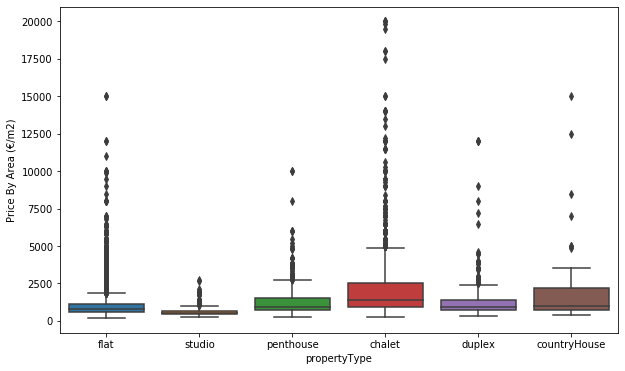

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x="propertyType", y="price", data=df)
plt.ylabel('Price By Area (€/m2)')
plt.show()

Comparing the total prices, as expected, we see that the chalets are much more expensive than the other property types, this is because chalets are usually much larger than other properties.

Comparing the prices between different flat sizes, now we are going to check if the prices will be influenced depending on the number of rooms for each flat. First of all, we can see the different averages of each number of rooms available in our dataset.

In [15]:
data = df.groupby('rooms')['price'].mean()
data

rooms
0      596.856934
1      717.650998
2      916.095456
3     1046.387993
4     1453.447314
5     2556.827423
6     3433.916667
7     4252.364865
8     5843.750000
9     4536.923077
10    3265.000000
11    2500.000000
12    4000.000000
13    5000.000000
14    4000.000000
15    6000.000000
18    6166.666667
30     740.000000
Name: price, dtype: float64

More or less, the prices can be more variable in each number of rooms, but we can see that more than 9 rooms the prices could not be more accurate because it can't be possible that 1 flat with 10 rooms is more expensive than one flat with 30 rooms.

Now we are going to see these results more accurately filtering by city and finding if these different numbers of rooms appear in each city or there are some numbers that exist in 1 city, so these results are not trusted.

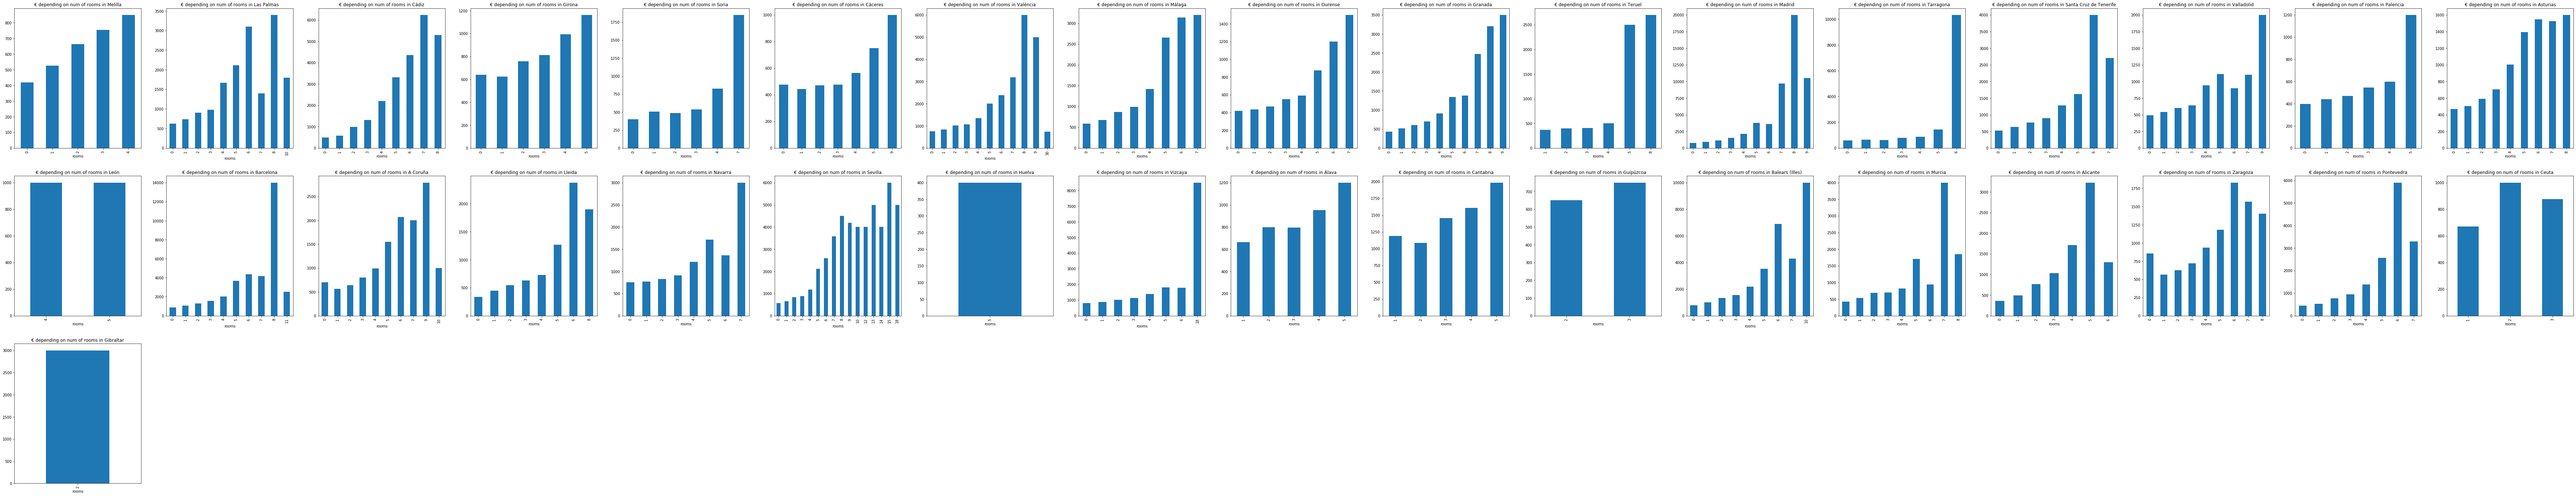

In [16]:
plt.figure(figsize=(100, 100))
n_states = len(df.province.unique())
for i, state in enumerate(df.province.unique(), start=1):
    plt.subplot(n_states // 2, n_states // 2, i)
    plt.title(f'€ depending on num of rooms in {state}')
    plt.subplots_adjust(right=1.1, top=1.2)
    df[df.province == state].groupby('rooms')['price'].mean().plot.bar()

As we can see before, there are some cities that exists a limited number of rooms than others. In some cases, the before average computed are not accurately in some number of rooms. Obviously, the number of rooms directly influences the prices of the house or flat, however, exists some exceptions how the type of house with 30 rooms that it's cheaper than one with 9 rooms in Valencia for example. In order to improve these results, we should need more houses where your quantity of rooms is equals to 30 rooms.

Depending on the state the correlation of the distance varies.

In [17]:
for state in df.province.unique():
    mask = df.province == state
    if df[mask].shape[0] > 1:
        corr, _ = scipy.stats.pearsonr(df[mask].distance.values, df[mask].priceByArea.values)
        print(f'Pearson correlation for {state} is {corr:.3f}')

Pearson correlation for Melilla is 0.248
Pearson correlation for Las Palmas is 0.152
Pearson correlation for Cádiz is 0.058
Pearson correlation for Girona is -0.275
Pearson correlation for Soria is -0.526
Pearson correlation for Cáceres is -0.223
Pearson correlation for València is -0.164
Pearson correlation for Málaga is -0.098
Pearson correlation for Ourense is -0.302
Pearson correlation for Granada is -0.131
Pearson correlation for Teruel is 0.320
Pearson correlation for Madrid is 0.350
Pearson correlation for Tarragona is -0.087
Pearson correlation for Santa Cruz de Tenerife is 0.070
Pearson correlation for Valladolid is -0.268
Pearson correlation for Palencia is 0.153
Pearson correlation for Asturias is 0.126
Pearson correlation for León is nan
Pearson correlation for Barcelona is -0.124
Pearson correlation for A Coruña is -0.175
Pearson correlation for Lleida is -0.014
Pearson correlation for Navarra is -0.146
Pearson correlation for Sevilla is -0.383
Pearson correlation for Vizc

The strongest scatter plot is the one resulting from Madrid. While the scatter plot with less correlation is from Barcelona.

## Rents in numbers

On this dataset, each line corresponds to an offer that one property owner does, seeking to rent their property to other people who are looking to rent flat or other types of properties.

Considering that our dataset is composed of offers on the most important cities in our country, we can see what type of flat is the most requested.

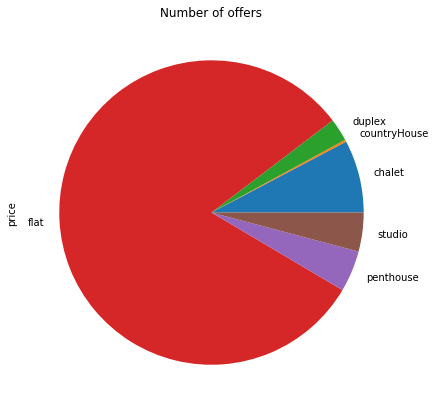

In [18]:
data = df.groupby('propertyType')['price'].count()
plt.subplots(figsize=(10,7))
plt.title('Number of offers')
data.plot.pie()

## Predective analysis

In [19]:
features_columns = [
    'numPhotos', 'floor', 'propertyType', 'size',
    'exterior', 'rooms', 'bathrooms', 'province',
    'latitude', 'longitude', 'showAddress', 'hasLift',
    'newDevelopment', 'hasPlan', 'has3DTour', 'has360',
    'parkingSpace_hasParkingSpace']
label = 'price'

In [20]:
X = df[features_columns].copy()

In [21]:
def floor_feature_eng(f):
    try:
        return 'high' if int(f) > 8 else 'low'
    except ValueError:
        return 'other'

In [22]:
X['floor'] = X.floor.apply(floor_feature_eng).astype('category')
X['propertyType'] = X.propertyType.astype('category')
X['province'] = X.province.astype('category')

In [23]:
ohe_floor = pd.get_dummies(X['floor'], prefix='floor')
X.drop('floor', axis='columns', inplace=True)
X = pd.concat([X, ohe_floor], axis=1)

ohe_state = pd.get_dummies(X['province'], prefix='province')
X.drop('province', axis='columns', inplace=True)
X = pd.concat([X, ohe_state], axis=1)

ohe_type = pd.get_dummies(X['propertyType'], prefix='type')
X.drop('propertyType', axis='columns', inplace=True)
X = pd.concat([X, ohe_type], axis=1)

X.head()

,numPhotos,size,exterior,rooms,bathrooms,latitude,longitude,showAddress,hasLift,newDevelopment,...,province_València,province_Vizcaya,province_Zaragoza,province_Álava,type_chalet,type_countryHouse,type_duplex,type_flat,type_penthouse,type_studio
0,10,55.0,True,1,1,35.297820,-2.941954,True,True,False,...,0,0,0,0,0,0,0,1,0,0
1,11,45.0,True,0,1,35.297820,-2.941954,True,True,False,...,0,0,0,0,0,0,0,0,0,1
2,18,65.0,True,2,1,35.297820,-2.941954,True,True,False,...,0,0,0,0,0,0,0,1,0,0
3,23,105.0,True,3,1,35.284242,-2.942115,True,False,False,...,0,0,0,0,0,0,0,1,0,0
4,22,75.0,True,2,2,35.280265,-2.938536,True,True,False,...,0,0,0,0,0,0,0,1,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, df[label], test_size=.3, shuffle=True, random_state=42)

In [25]:
random_forest = RandomForestRegressor(max_depth=10, n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [26]:
preds = random_forest.predict(X_test)
mean_absolute_error(y_test, preds)

222.92104178195933